In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
#from scipy.stats import gaussian_kde


In [2]:
adatad=sc.read("DENV2_adatad.h5ad")

In [3]:
print(adatad.obs["leiden"].unique())

['0', '1']
Categories (2, object): ['0', '1']


## Assign clusters

In [5]:
adatad.obs["cluster"] = adatad.obs["leiden"].map(
    {
        "0": "quiescent_response",
        "1": "active_response",
    }
)

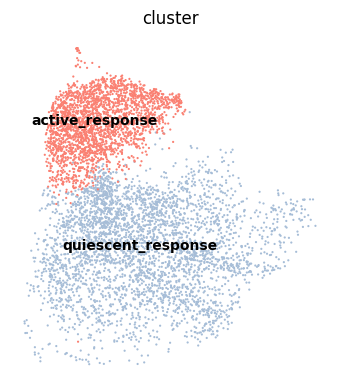

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

# Custom color map
palette = {'active_response': 'salmon', 'quiescent_response': "#A6BDD7"}

# Plot UMAP with custom palette and retrieve figure
fig = sc.pl.umap(
    adatad, 
    color='cluster',
    palette=palette,
    size=10,
    frameon=False,
    legend_loc='on data',
    show=False
)

# Resize figure
fig = plt.gcf()
fig.set_size_inches(3.5, 4)

# Optional: adjust layout and save
plt.tight_layout()
plt.savefig("umap_dengue_clusters.pdf", format='pdf', bbox_inches='tight')
plt.show()


## Plot CC score, viral load for figure

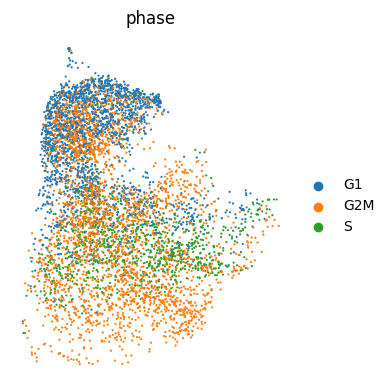

In [9]:
# Set figure size (width, height in inches); make it small and square
fig = sc.pl.umap(adatad, color=['phase'], wspace=0.5,
    size=10, show=False, frameon=False)

fig = plt.gcf()
fig.set_size_inches(4, 4)  # Set to desired width, height in inches

plt.tight_layout()
#plt.savefig("umap_dengue_plot_cc.pdf", format='pdf', bbox_inches='tight')
plt.show()

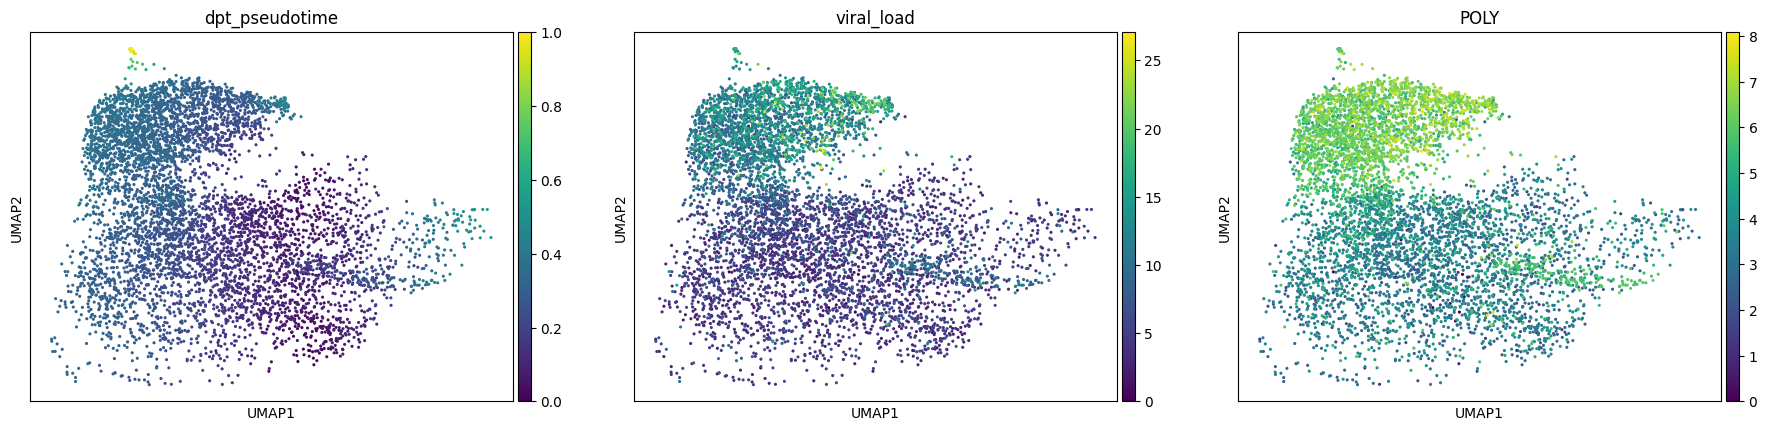

In [13]:
## PSEUDOTIME
# 
sc.pp.neighbors(adatad, n_neighbors=30, n_pcs=30)  # bump neighbors from 15 → 30
sc.tl.diffmap(adatad)

poly_expr = adatad[:, "POLY"].X.toarray().flatten()
adatad.uns['iroot'] = np.argmin(poly_expr)

sc.tl.dpt(adatad)

sc.pl.umap(adatad, color=['dpt_pseudotime', 'viral_load', 'POLY'], cmap='viridis')


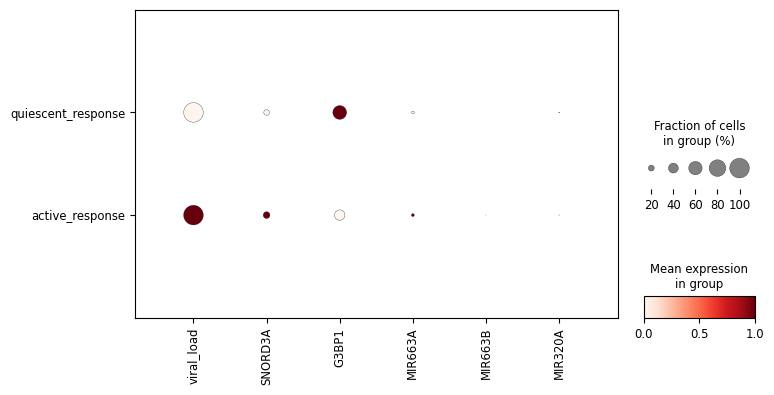

In [14]:
sc.pl.dotplot(
    adatad,
    var_names=["viral_load", "SNORD3A", "G3BP1", "MIR663A","MIR663B", "MIR320A"],
    groupby="cluster",
    standard_scale="var",
    color_map="Reds",
    figsize=(8, 4)
)


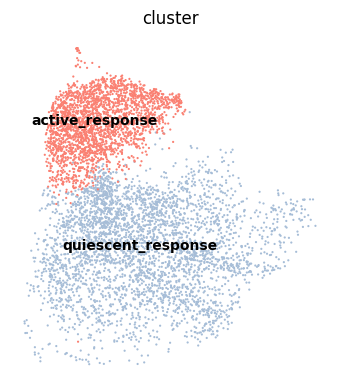

In [15]:
# Plot UMAP with custom palette and retrieve figure
fig = sc.pl.umap(
    adatad, 
    color='cluster',
    palette=palette,
    size=10,
    frameon=False,
    legend_loc='on data',
    show=False
)

# Resize figure
fig = plt.gcf()
fig.set_size_inches(3.5, 4)

# Optional: adjust layout and save
plt.tight_layout()
plt.savefig("umap_dengue_clusters.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Correlate genes with viral load

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Make sure adata is scaled or log-normalized appropriately
# We'll use the dense matrix of shape (cells x genes)
X = adatad.X.toarray() if hasattr(adatad.X, "toarray") else adatad.X  # shape: cells x genes

# Get viral load vector
viral_load = adatad.obs['viral_load'].values

# Initialize list for results
cor_results = []

# Loop through genes
for i, gene in enumerate(adatad.var_names):
    gene_expr = X[:, i]
    if np.std(gene_expr) > 0:  # Avoid division by zero
        r, p = pearsonr(gene_expr, viral_load)
        cor_results.append((gene, r, p))

# Convert to DataFrame
cor_df = pd.DataFrame(cor_results, columns=["gene", "correlation", "pval"])
cor_df["abs_corr"] = cor_df["correlation"].abs()

# Sort by strongest correlations
cor_df_sorted = cor_df.sort_values("abs_corr", ascending=False)

# Top positively correlated genes
cor_df_sorted.head(20)

# Top negatively correlated genes
#cor_df_sorted.sort_values("correlation").head(20)

# Define genes to remove
genes_to_remove = ['sfRNA1', 'sfRNA2', 'sfRNA3', 'sfRNA4', "POLY"]
cor_df = cor_df[~cor_df["gene"].isin(genes_to_remove)].copy()


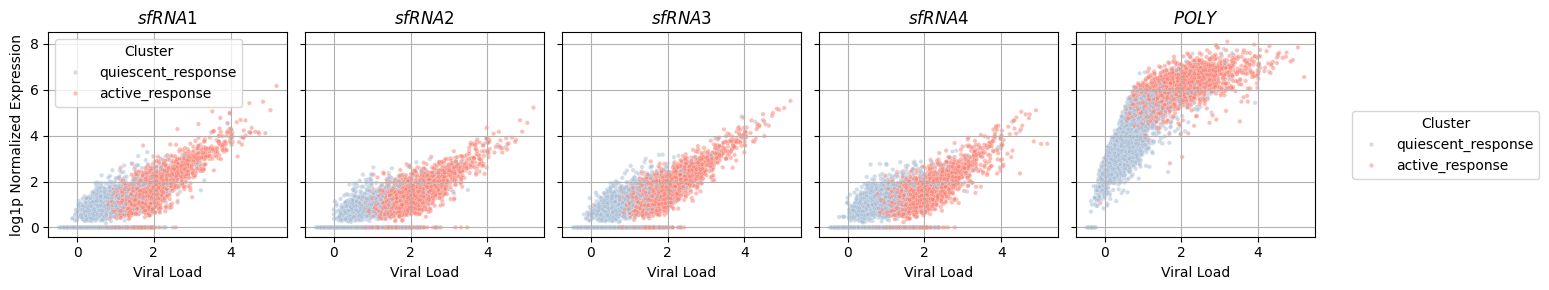

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Gene list
top_genes = ['sfRNA1', 'sfRNA2', 'sfRNA3', 'sfRNA4', 'POLY']

# Extract data
cluster = adatad.obs['cluster'].astype(str)
viral_load = adatad.obs['viral_load_score'].values

# Create figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(top_genes), figsize=(len(top_genes)*3, 3), sharey=True)

for i, (ax, gene_name) in enumerate(zip(axes, top_genes)):
    gene_expr = adatad[:, gene_name].X.toarray().flatten()

    df = pd.DataFrame({
        'Gene Expression': gene_expr,
        'Viral Load': viral_load,
        'Cluster': cluster
    })

    sns.scatterplot(
        data=df,
        x='Viral Load',
        y='Gene Expression',
        hue='Cluster',
        palette=palette,
        s=10,
        alpha=0.5,
        ax=ax,
        legend=(i == 0)  # only first plot gets legend
    )

    ax.set_title(r"$\it{" + gene_name + "}$")
    ax.set_xlabel("Viral Load")
    if ax == axes[0]:
        ax.set_ylabel("log1p Normalized Expression")
    else:
        ax.set_ylabel("")
    ax.grid(True)

# One legend on the side
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Cluster", bbox_to_anchor=(0.9, 0.5), loc="center left")

plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.savefig("Viral_load_spread.pdf", format='pdf', bbox_inches='tight')
plt.show()



/tmp/ipykernel_31716/1815732372.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Oranges")
/home/users/isakova/.local/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


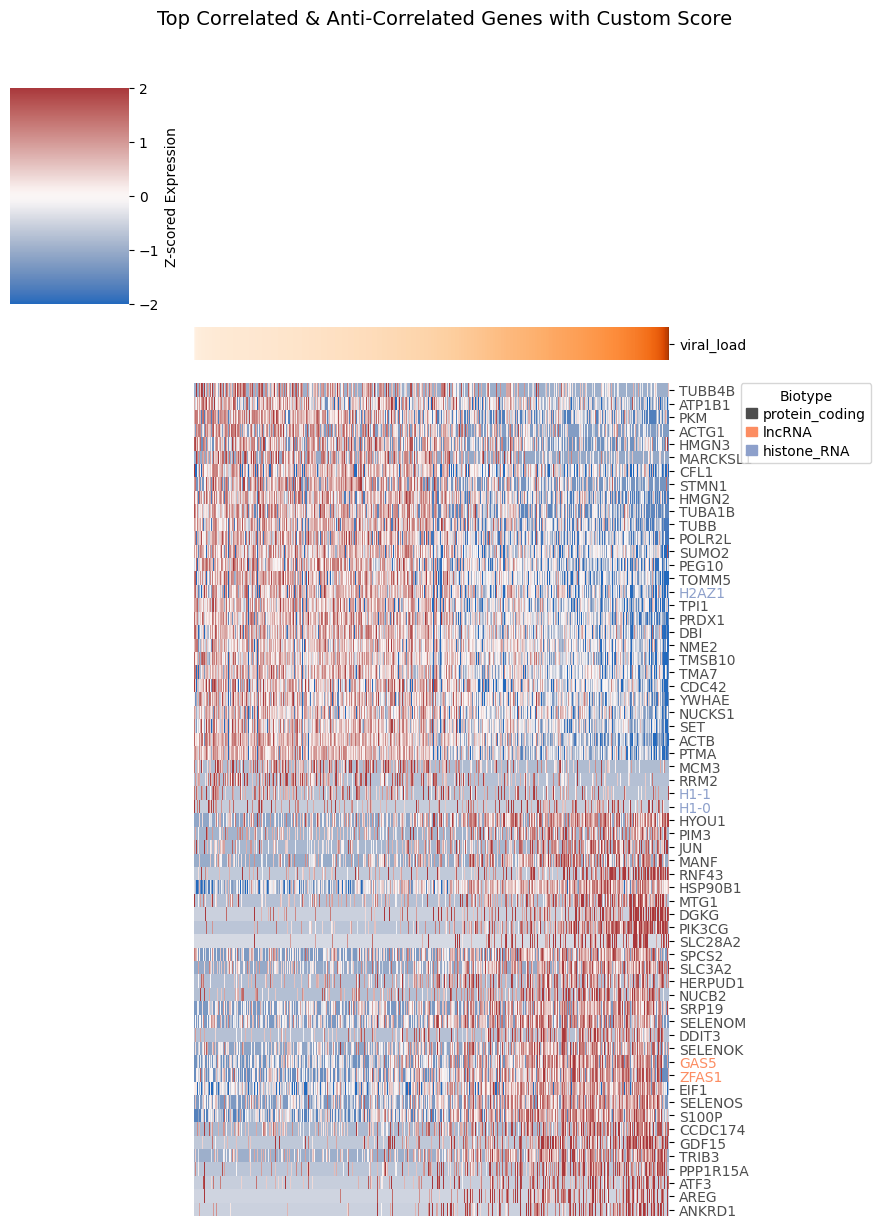

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Parameters
cor_genes = 30

# Top 50 positively and negatively correlated genes
top_pos_genes = cor_df.sort_values('correlation', ascending=False).head(cor_genes)['gene'].tolist()
top_neg_genes = cor_df.sort_values('correlation', ascending=True).head(cor_genes)['gene'].tolist()

# Add extra genes
extra_genes1 = ["H1-0"] #"MIR663A",
extra_genes2 = [ "H1-1"] #"MIR663A",
heatmap_genes = list(dict.fromkeys(top_pos_genes + extra_genes1 + top_neg_genes + extra_genes2))

# Sort adata by viral_load
adata_sorted = adatad[adatad.obs['viral_load'].sort_values().index].copy()

# Extract expression matrix (genes x cells)
X = pd.DataFrame(
    adata_sorted[:, heatmap_genes].X.toarray()
    if hasattr(adata_sorted[:, heatmap_genes].X, "toarray")
    else adata_sorted[:, heatmap_genes].X,
    columns=heatmap_genes,
    index=adata_sorted.obs_names
).T

# Z-score expression per gene
X_z = X.sub(X.mean(axis=1), axis=0).div(X.std(axis=1), axis=0)
X_z_clipped = X_z.clip(-2, 2)

# Create column colors (based on viral load)
norm = mcolors.Normalize(vmin=adata_sorted.obs['viral_load'].min(), vmax=adata_sorted.obs['viral_load'].max())
cmap = cm.get_cmap("Oranges")
score_colors = [mcolors.to_hex(cmap(norm(v))) for v in adata_sorted.obs['viral_load']]
col_colors = pd.Series(score_colors, index=adata_sorted.obs_names, name="viral_load")

# --- Biotype Row Coloring ---
# Extract biotypes from adata.var
biotypes = adata_sorted.var.loc[heatmap_genes, "biotype"]
biotypes = biotypes.reindex(X_z_clipped.index)  # ensure alignment

# Create color palette for biotypes
unique_biotypes = biotypes.dropna().unique()
biotype_palette = sns.color_palette("Set2", n_colors=len(unique_biotypes))
biotype_color_map = dict(zip(unique_biotypes, biotype_palette))
# Custom override for protein_coding
biotype_color_map["protein_coding"] = "#4D4D4D"  # dark gray
#biotype_color_map["virus"]= sns.color_palette("Set2")[1]

# Map each gene to its biotype color
row_colors = biotypes.map(biotype_color_map)

g = sns.clustermap(
    X_z_clipped,
    col_cluster=False,
    row_cluster=True,  # still cluster the rows
    col_colors=col_colors,
    cmap="vlag",
    xticklabels=False,
    yticklabels=True,
    figsize=(9, 12),
    cbar_kws={
        'label': 'Z-scored Expression',
        'shrink': 0.5,  # shrink the height (vertical) of colorbar
        'aspect': 30    # lower = wider bar (horizontal size)
    }
)

# Hide dendrograms visually
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

# Adjust layout to reclaim space
g.fig.subplots_adjust(left=0.15, top=0.9)

# Title
plt.suptitle("Top Correlated & Anti-Correlated Genes with Custom Score", y=1.02, fontsize=14)

# Color gene name labels by biotype
row_ticklabels = g.ax_heatmap.get_yticklabels()
row_gene_order = X_z_clipped.index[g.dendrogram_row.reordered_ind]

for label, gene in zip(row_ticklabels, row_gene_order):
    label.set_color(biotype_color_map.get(biotypes.get(gene, None), "black"))

# Legend for biotypes
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=bt) for bt, color in biotype_color_map.items()]
g.ax_heatmap.legend(
    handles=legend_patches,
    title="Biotype",
    bbox_to_anchor=(1.15, 1),  # closer to the heatmap
    loc='upper left',
    borderaxespad=0,
    handlelength=0.8,          # shorter color blocks
    handletextpad=0.4,         # tighter between block and label
    labelspacing=0.3,          # tighter vertical spacing
    #fontsize='small',          # smaller font if needed
    title_fontsize='medium'    # adjust title size too
)
plt.tight_layout()
#plt.savefig("viral_heatmap_denv2.pdf", format="pdf", bbox_inches="tight")
plt.show()



/tmp/ipykernel_31716/184368818.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viral_cmap = cm.get_cmap("Oranges")


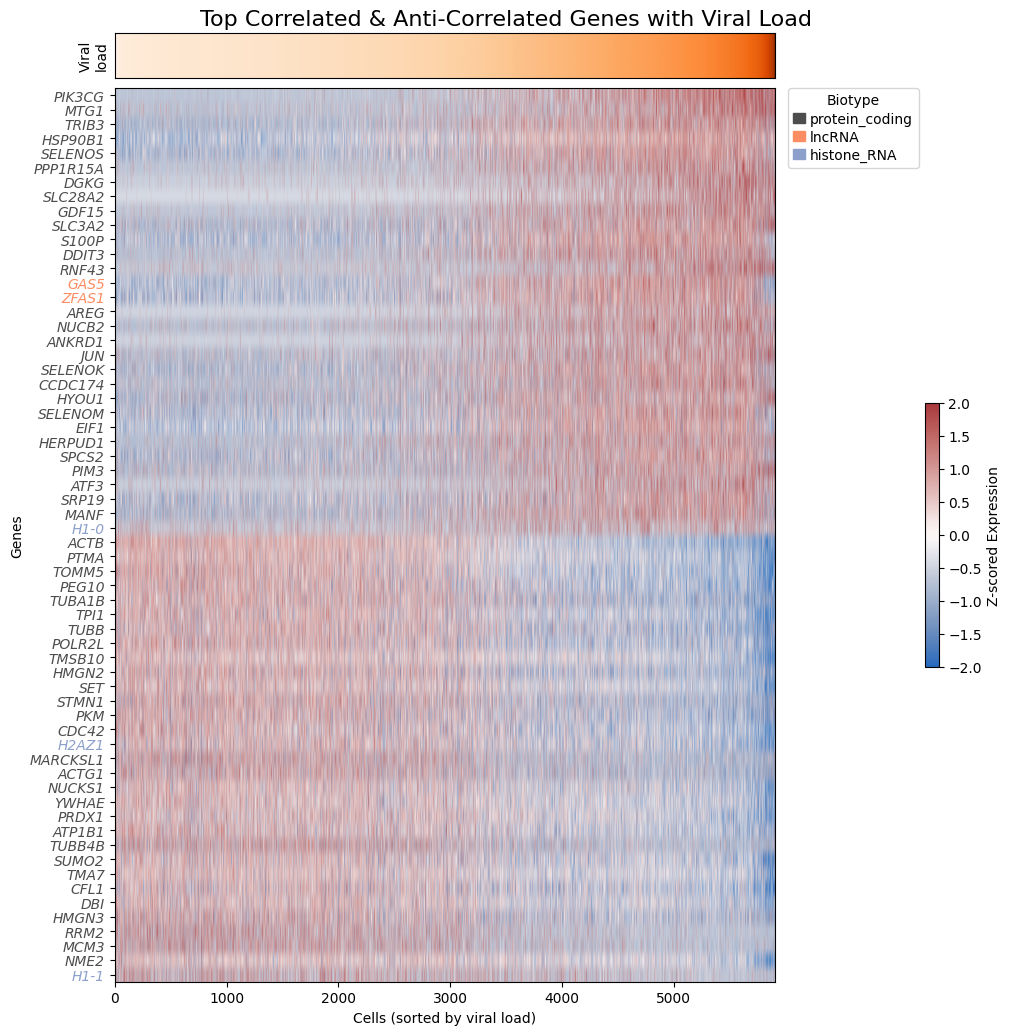

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# --- Setup ---
expr_matrix = X_z_clipped.values
selected_genes = X_z_clipped.index.tolist()
cells = X_z_clipped.columns.tolist()

# --- Viral load color bar ---
viral_load = adata_sorted.obs.loc[cells, 'viral_load']
vmin, vmax = viral_load.min(), viral_load.max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
viral_cmap = cm.get_cmap("Oranges")
viral_bar = np.array([viral_cmap(norm(v)) for v in viral_load])

# --- Plotting ---
fig, axes = plt.subplots(nrows=2, figsize=(10, 10), 
                         gridspec_kw={'height_ratios': [0.05, 1]},
                         constrained_layout=True)

# 1. Viral load bar
axes[0].imshow(viral_bar[np.newaxis, :, :], aspect='auto')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_ylabel("Viral\nload")

# 2. Expression heatmap
im = axes[1].imshow(expr_matrix, aspect='auto', cmap='vlag', vmin=-2, vmax=2) #'coolwarm'
axes[1].set_xlabel("Cells (sorted by viral load)")
axes[1].set_ylabel("Genes")
axes[1].set_yticks(np.arange(len(selected_genes)))
axes[1].set_yticklabels(selected_genes)

# Colorbar for expression values
cbar = fig.colorbar(im, ax=axes[1], orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label("Z-scored Expression")

# --- Color y-axis gene labels by biotype ---
biotypes_reindexed = biotypes.reindex(selected_genes)

for tick_label, gene in zip(axes[1].get_yticklabels(), selected_genes):
    color = biotype_color_map.get(biotypes_reindexed.get(gene), "black")
    tick_label.set_color(color)
    tick_label.set_fontstyle('italic')

# --- Legend for biotypes ---
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color=color, label=bt) for bt, color in biotype_color_map.items()
]

axes[1].legend(
    handles=legend_patches,
    title="Biotype",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    handlelength=0.8,
    handletextpad=0.4,
    labelspacing=0.3,
    title_fontsize='medium'
)

# Title
plt.suptitle("Top Correlated & Anti-Correlated Genes with Viral Load", y=1.02, fontsize=16)

# Save + Show
plt.savefig("viral_heatmap_simple.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Explore genes correlated with viral load but not POLY

In [26]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Use your AnnData object
X = adatad.X.toarray() if hasattr(adatad.X, "toarray") else adatad.X
gene_names = adatad.var_names

# Get viral load from obs
viral_load = adatad.obs['viral_load'].values

# Get expression vector of the POLY gene (from var_names)
poly_expr = adatad[:, 'POLY'].X.toarray().flatten() if hasattr(adatad[:, 'POLY'].X, "toarray") else np.ravel(adatad[:, 'POLY'].X)
sfrna_load = adatad.obs['sfrna_load'].values
# Compute correlations
results = []
for i, gene in enumerate(gene_names):
    expr = X[:, i]
    if np.std(expr) > 0:
        r_vl, _ = pearsonr(expr, viral_load)
        r_poly, _ = pearsonr(expr, poly_expr)
        r_sfrna, _ = pearsonr(expr, sfrna_load)
        results.append((gene, r_vl, r_poly, r_sfrna, r_sfrna - r_poly,r_poly - r_sfrna ))

# Store as DataFrame
cor_df = pd.DataFrame(results, columns=['gene', 'corr_viral_load', 'corr_POLY', 'corr_sfrna', 'corr_diff1', 'corr_diff2'])



11 [-0.2961726339  0.9654329119]
27 [-0.3823234263  0.9261719938]
18 [ 0.9962111461 -0.6623359182]
26 [0.5890675125 0.1896068318]
8 [-0.0242077755 -0.7171443278]
31 [-0.5675393022  0.8487180945]
1 [-0.8053375354 -0.5412451759]
30 [-0.92887142  -0.403237559]


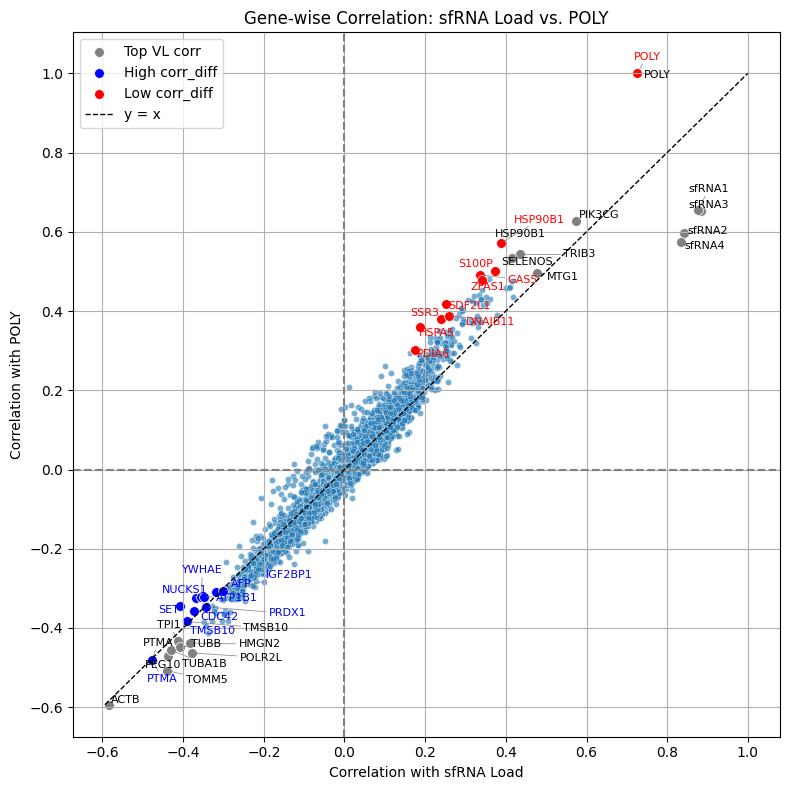

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text


# Number of genes to select from each end
top_n = 10

# Top positively correlated
top_pos = cor_df.sort_values('corr_viral_load', ascending=False).head(top_n)

# Top negatively correlated
top_neg = cor_df.sort_values('corr_viral_load', ascending=True).head(top_n)

# Combine into one DataFrame
selected_genes = pd.concat([top_pos, top_neg])

# Start plot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=cor_df, x='corr_sfrna', y='corr_POLY', s=20, alpha=0.6)

# Axis lines
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

# Initial labels: viral load extremes
texts = []
sns.scatterplot(
    data=selected_genes,
    x='corr_sfrna',
    y='corr_POLY',
    color='gray',
    s=50,
    label='Top VL corr'
)
for _, row in selected_genes.iterrows():
    texts.append(
        plt.text(row['corr_sfrna'], row['corr_POLY'], row['gene'], fontsize=8, color='black')
    )

# Top genes with highest positive corr_diff and abs(POLY) > 0.3
top_diff = cor_df[
    (cor_df['corr_sfrna'] < -0.3 )
].sort_values('corr_diff1', ascending=True).head(top_n) 

sns.scatterplot(
    data=top_diff,
    x='corr_sfrna',
    y='corr_POLY',
    color='blue',
    s=50,
    label='High corr_diff'
)

texts_diff_pos = []
for _, row in top_diff.iterrows():
    texts_diff_pos.append(
        plt.text(row['corr_sfrna'], row['corr_POLY'], row['gene'], fontsize=8, color='blue')
    )



# Top genes with most negative corr_diff and abs(POLY) > 0.3
top_diff_neg = cor_df[
    (cor_df['corr_POLY'].abs() > 0.3)
].sort_values('corr_diff2', ascending=False).head(top_n)

sns.scatterplot(
    data=top_diff_neg,
    x='corr_sfrna',
    y='corr_POLY',
    color='red',
    s=50,
    label='Low corr_diff'
)

texts_diff_neg = []
for _, row in top_diff_neg.iterrows():
    texts_diff_neg.append(
        plt.text(row['corr_sfrna'], row['corr_POLY'], row['gene'], fontsize=8, color='red')
    )

# Repel all labels
adjust_text(texts + texts_diff_pos + texts_diff_neg, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Final plot tweaks
plt.xlabel('Correlation with sfRNA Load')
plt.ylabel('Correlation with POLY')
plt.title('Gene-wise Correlation: sfRNA Load vs. POLY')
# Add diagonal line y = x
lims = [
    np.min([cor_df['corr_sfrna'].min(), cor_df['corr_POLY'].min()]),
    np.max([cor_df['corr_sfrna'].max(), cor_df['corr_POLY'].max()]),
]
plt.plot(lims, lims, '--', color='black', linewidth=1, label='y = x')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("correation_viral_load.pdf", format="pdf", bbox_inches="tight")

plt.show()


### Some comparisons to previous studies

In [76]:
adatad = adata[adata.obs['source'] == 'Huh7-DENV2'].copy()# Define your viral gene names
virus_genes = ["sfRNA1", "sfRNA2", "sfRNA3", "sfRNA4", "POLY"]

# Confirm which of these are present in your AnnData object
virus_genes_present = [g for g in virus_genes if g in adata.var_names]
print("Viral genes found in dataset:", virus_genes_present)

# Sum viral UMI counts per cell
counts = adatad.layers["counts"]
viral_counts = counts[:, adatad.var_names.isin(virus_genes_present)].sum(axis=1).A1

# Store in .obs
adatad.obs["viral_counts"] = viral_counts
adatad.obs["virus_positive"] = adatad.obs["viral_counts"] > 1

fraction_virus_positive = adatad.obs["virus_positive"].mean()
print(f"Fraction of virus-positive cells: {fraction_virus_positive:.2%}")


Viral genes found in dataset: ['sfRNA1', 'sfRNA2', 'sfRNA3', 'sfRNA4', 'POLY']
Fraction of virus-positive cells: 99.56%


In [77]:
viral_summary = adatad.obs.loc[adatad.obs["virus_positive"], "viral_counts"].describe()
print(viral_summary)


count    5877.000000
mean      262.386932
std       433.242004
min         2.000000
25%        20.000000
50%        78.000000
75%       336.000000
max      7098.000000
Name: viral_counts, dtype: float64


In [78]:
# Mask to exclude your viral genes
host_gene_mask = ~adatad.var_names.isin(virus_genes_present)

# Count number of host genes with >0 UMI per cell
host_gene_counts = (counts[:, host_gene_mask] > 0).sum(axis=1).A1
adatad.obs["n_host_genes"] = host_gene_counts

# Compare between virus+ and virus− cells
host_gene_stats = adatad.obs.groupby("virus_positive")["n_host_genes"].describe()
print(host_gene_stats)


                 count         mean          std     min     25%     50%  \
virus_positive                                                             
False             26.0  1799.423077   461.602095  1130.0  1439.5  1724.5   
True            5877.0  2861.387272  1186.219198   999.0  1972.0  2631.0   

                   75%     max  
virus_positive                  
False           2179.5  2692.0  
True            3506.0  6984.0  


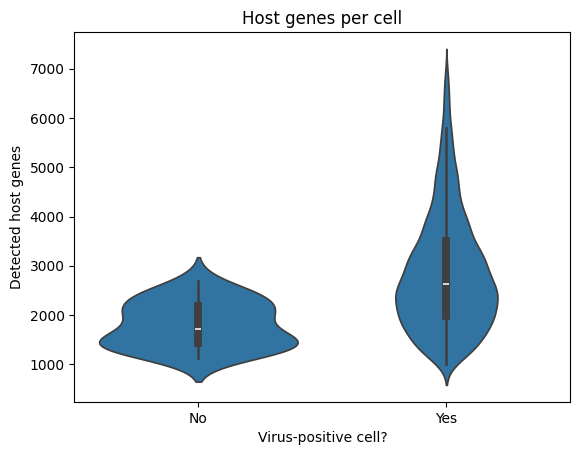

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(x="virus_positive", y="n_host_genes", data=adatad.obs)
plt.title("Host genes per cell")
plt.xlabel("Virus-positive cell?")
plt.ylabel("Detected host genes")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()


In [80]:
import pandas as pd

summary = pd.DataFrame({
    "Metric": [
        "Fraction virus-positive cells",
        "Median viral UMIs (virus+ cells)",
        "Median host genes (virus+)",
        "Median host genes (virus−)"
    ],
    "Value": [
        adatad.obs["virus_positive"].mean(),
        adatad.obs.loc[adatad.obs["virus_positive"], "viral_counts"].median(),
        adatad.obs.loc[adatad.obs["virus_positive"], "n_host_genes"].median(),
        adatad.obs.loc[~adatad.obs["virus_positive"], "n_host_genes"].median()
    ]
})
print(summary)


                             Metric        Value
0     Fraction virus-positive cells     0.995595
1  Median viral UMIs (virus+ cells)    78.000000
2        Median host genes (virus+)  2631.000000
3        Median host genes (virus−)  1724.500000


In [81]:
total_counts = adatad.layers["counts"].sum(axis=1).A1
adatad.obs["total_counts"] = total_counts
adatad.obs["viral_per_10k"] = (adatad.obs["viral_counts"] / total_counts) * 10000


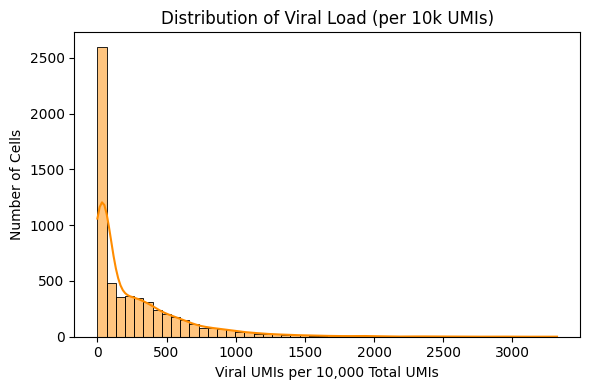

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.histplot(adatad.obs["viral_per_10k"], bins=50, kde=True, color="darkorange")
plt.xlabel("Viral UMIs per 10,000 Total UMIs")
plt.ylabel("Number of Cells")
plt.title("Distribution of Viral Load (per 10k UMIs)")
plt.tight_layout()
plt.savefig("viral_load_per_10K_UMIs.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [83]:
adatad.obs["pct_viral_reads"] = adatad.obs["viral_per_10k"] / 100

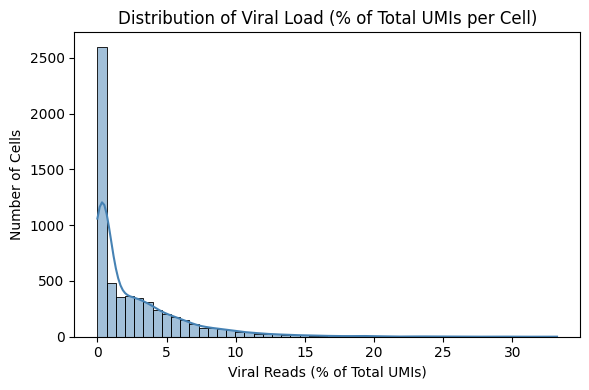

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.histplot(adatad.obs["pct_viral_reads"], bins=50, kde=True, color="steelblue")
plt.xlabel("Viral Reads (% of Total UMIs)")
plt.ylabel("Number of Cells")
plt.title("Distribution of Viral Load (% of Total UMIs per Cell)")
plt.tight_layout()
plt.show()
